In [3]:
import scanpy as sc
import anndata as ad
import rpy2
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
import seaborn as sns
from glob import glob
from scipy.sparse import csr_matrix
import numpy as np
import os
os.chdir("/data")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
paths = glob("cellranger/*/qc_filtered.h5ad")
adata_list=[] #reading files
names=[]
for n in paths:
    adata = sc.read_h5ad(n)
    sample = n.split("/")[1]
    adata.obs["sample_id"]=sample
    adata.obs["condition"]=sample.split("-")[0]
    adata_list.append(adata)
    names.append(sample)

In [6]:
adata=ad.concat(adata_list, index_unique="-", keys=names) #creating one object

In [7]:
del adata_list # deleting list to save memory

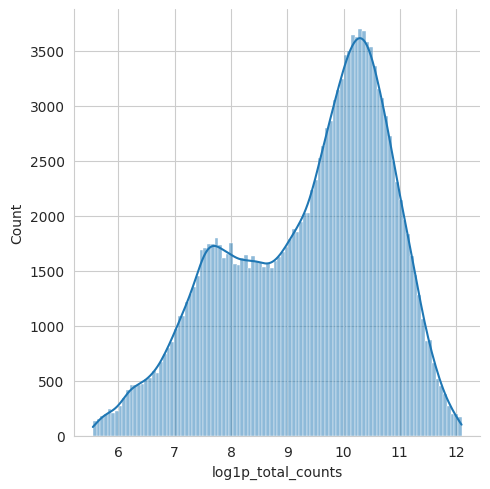

In [8]:
counts_lower=2.5
counts_upper=2
p1 = sns.displot(adata.obs["log1p_total_counts"], bins=100, kde=True)

In [9]:
#adata=adata[adata.obs["total_counts"]>1000] #minimum counts of 1000, sample filtering done per sample
#generally; mt<8%, while outliers are eliminated based on counts and ngenes

In [10]:
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
adata.layers["cellbender"] = csr_matrix(adata.layers["cellbender"],dtype=np.float32)
adata.layers["raw"] = csr_matrix(adata.layers["raw"],dtype=np.float32)
adata.layers["counts"]=adata.layers["cellbender"]
del adata.layers["cellbender"]
adata.X = adata.layers["counts"].copy()
## converting to float32 matrices because of a weird bug in converting int64 matrices to R

In [12]:
adata.write_h5ad("full_h5ad.h5")

In [13]:
%%R -i adata
library(BiocParallel)
library(scDblFinder)
adata
assays(adata)

List of length 3
names(3): X raw counts


In [14]:
del adata

In [15]:
%%R
assays(adata) <- assays(adata)[3]

In [16]:
%%R
adata <- scDblFinder(adata, samples="sample_id", BPPARAM=MulticoreParam(2))

In [17]:
%%R -o adata
adata

class: SingleCellExperiment 
dim: 29594 158236 
metadata(0):
assays(1): X
rownames(29594): Xkr4 Gm1992 ... ENSMUSG00000095742 ENSMUSG00000095041
rowData names(1): n_cells
colnames(158236): TGGTGATGTATCCTCC-1-cd40-1 AGGTTGTGTAAGATCA-1-cd40-1
  ... CAGCGTGAGAATTTGG-1-tak-2 GAAGAATGTTGGCTAT-1-tak-2
colData names(26): background_fraction cell_probability ...
  scDblFinder.weighted scDblFinder.cxds_score
reducedDimNames(1): cellbender_embedding
mainExpName: NULL
altExpNames(0):


In [18]:
%R rm(adata)
adata_full = sc.read_h5ad("full_h5ad.h5")

In [19]:
adata_full.obs = adata.obs.copy()
adata=adata_full.copy()
del adata_full

In [20]:
print(f"Number of doublets: {adata[adata.obs['scDblFinder.class']=='doublet'].n_obs}")

Number of doublets: 25944


In [21]:
adata.raw = adata #saving raw copy with doublets just in case we want to change something about this

In [22]:
adata=adata[adata.obs["scDblFinder.class"]=="singlet"].copy()

In [23]:
adata.raw.var.index=adata.raw.var.index.astype(str)
adata.obs.index=adata.obs.index.astype(str)
adata.var.index=adata.var.index.astype(str)

In [24]:
adata.write_h5ad("h5ad/doublet_filtered.h5ad")